# Load and preprocess dataset

Load and merge data into pandas dataframe

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib import cm as cm

from scipy.sparse.linalg import svds
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
#load data
unames =  ['user','gender','age','occupation','zip']
users = pd.read_table('users.dat', sep = '::', engine = 'python', names = unames)

rnames = ['user', 'movie', 'rating', 'timestamp']
ratings = pd.read_table('ratings.dat', sep = '::', engine = 'python', names = rnames)

mnames = ['movie','title','genres']
movies = pd.read_table('movies.dat', sep = '::', engine = 'python', names = mnames)

# we convert the movie genres to a set of dummy variables 
#movies = pd.concat([movies, movies.genres.str.get_dummies(sep='|')], axis=1)  
#movies.head()

#merge into dataframe
data = pd.merge(pd.merge(users, ratings), movies)

Check how many movies are there

In [18]:
print('there are ',len(movies.index),' movies in the dataset')

there are  3883  movies in the dataset


# Quick glimpse at genres

Genre distribution of movies

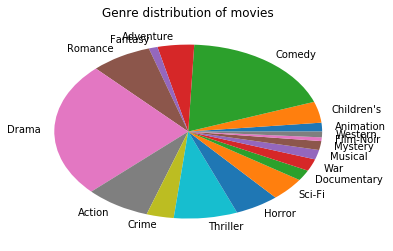

[]

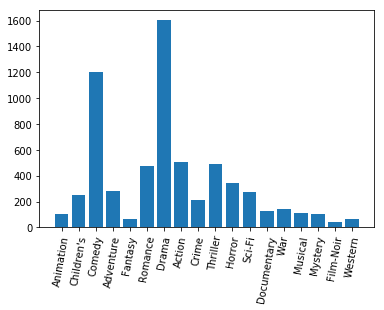

In [7]:
#add column genres_split with vector of genres for each movie
movies['genres_split'] = movies['genres'].str.split('|')

# add column which counts the number of genres for each movie
counter_lambda = lambda x: len(x)
movies['genre_count'] = movies.genres_split.apply(counter_lambda)
movies.head()

# count number of movies for each genre
from collections import Counter
genres = [item for sublist in movies.genres_split for item in sublist]
genre_dict = dict(Counter(genres))

# plot genre distribution as a pie chart
plt.pie(genre_dict.values(), labels=genre_dict.keys())
plt.title('Genre distribution of movies')
plt.show()

# same as a bar chart
x = list(range(len(genre_dict)))
plt.xticks(x, genre_dict.keys(), rotation=80)
plt.bar(x, genre_dict.values())
plt.plot()

Genres watched together

Genres watched together


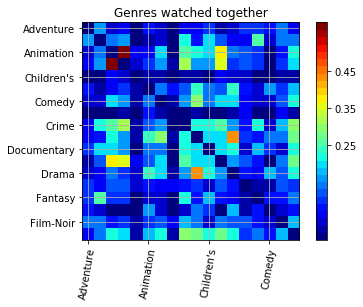

Top genres watched together
Fantasy     Children's    0.319148
Children's  Fantasy       0.319148
Musical     Children's    0.366240
Children's  Musical       0.366240
Musical     Animation     0.380087
Animation   Musical       0.380087
Film-Noir   Mystery       0.433980
Mystery     Film-Noir     0.433980
Children's  Animation     0.583990
Animation   Children's    0.583990
dtype: float64


In [78]:
print('Genres watched together')

df = data[['user','genres']]
# we convert the movie genres to a set of dummy variables 
df = pd.concat([df, df.genres.str.get_dummies(sep='|')], axis=1) 
df = df.drop(['genres'],axis=1)

grouped = df.groupby(['user']).sum()
grouped = grouped/grouped
grouped = grouped.replace(np.nan,0)

c = grouped.corr()
c = c.replace(1,0)

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(c, interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title('Genres watched together')
#labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
ax1.set_xticklabels(grouped.columns,rotation=80)
ax1.set_yticklabels(grouped.columns)
fig.colorbar(cax, ticks=[.25,.35,.45,.60,.80,1])
plt.show()

s = c.unstack()
so = s.sort_values(kind="quicksort")

print('Top genres watched together')
print(so.tail(10))

# Quick glimpse at ratings

3706 movies have been rated


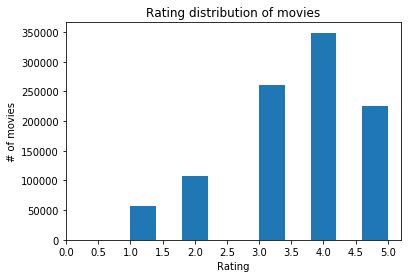

In [10]:
# how many movies have been rated
print (len(ratings.movie.unique()), 'movies have been rated')

# histogram of ratings
plt.hist(ratings.rating)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlabel('Rating')
plt.ylabel('# of movies')
plt.title('Rating distribution of movies')
plt.show()

In [19]:
print('Top rated movies')

ratings_view = ratings[['movie', 'rating']]
ratings_view.groupby(['movie'], as_index=False).mean().sort_values(by='rating', ascending=False).head(10)
# merge movies and ratings so that we can see the actual movie titles
merged_df = pd.merge(ratings, movies, on='movie')
titles_df = merged_df[['movie', 'title', 'rating']]
# take only movies which have at least 250 ratings
temp_df = titles_df.groupby(['movie', 'title'], as_index=False).count()
well_rated_df = temp_df[temp_df['rating'] > 250].sort_values(by='rating', ascending=False)
# filter df
filtered_df = merged_df[merged_df['movie'].apply(lambda x: x in list(well_rated_df['movie']))]
titles_df = filtered_df[['title', 'rating', 'movie']]
titles_df.groupby(['movie', 'title'], as_index=False).mean().sort_values(by='rating', ascending=False).head(10)

Top rated movies


,movie,title,rating
637,2019,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510
93,318,"Shawshank Redemption, The (1994)",4.554558
232,858,"Godfather, The (1972)",4.524966
212,745,"Close Shave, A (1995)",4.520548
24,50,"Usual Suspects, The (1995)",4.517106
162,527,Schindler's List (1993),4.510417
336,1148,"Wrong Trousers, The (1993)",4.507937
255,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.491489
349,1198,Raiders of the Lost Ark (1981),4.477725
241,904,Rear Window (1954),4.476190


# Identifying clusters of users and building recommendation system via matrix factorization

In [3]:
# reformat ratings matrix: rows users; columns movies
Ratings = ratings.pivot(index = 'user', columns ='movie', values = 'rating').fillna(0)
# data normalization
R = Ratings.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
Ratings_n = R - user_ratings_mean.reshape(-1, 1)

#apply SVD to ratings
U, sigma, Vt = svds(Ratings_n, k = 50)
sigma = np.diag(sigma)
embeding = U

Try clustering with PCA

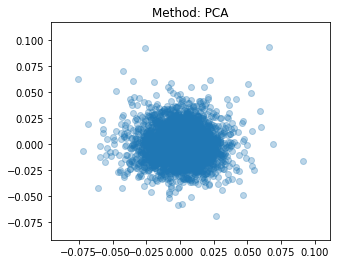

In [10]:
#then reduce dimensionality to 2
X_PCA = PCA(n_components = 2).fit_transform(embeding)
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

ax.scatter(X_PCA[:,0], X_PCA[:,1], alpha = 0.3)
plt.title('Method: PCA')
#plt.savefig('PCA.png', dpi = 300)
plt.show()

Try clustering with T-SNE

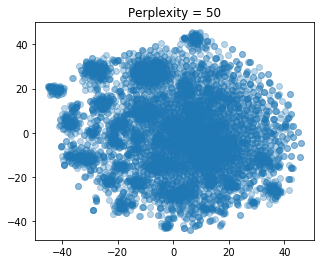

In [12]:
# use t-sne to reduce dim to 2
X_50_iter5000 = TSNE(n_components=2, perplexity = 50, random_state=0).fit_transform(embeding)

fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)
ax.scatter(X_50_iter5000[:,0], X_50_iter5000[:,1], alpha = 0.3)
ax.set_title('Perplexity = 50')

plt.show()

Visualising clusters with DBSCAN

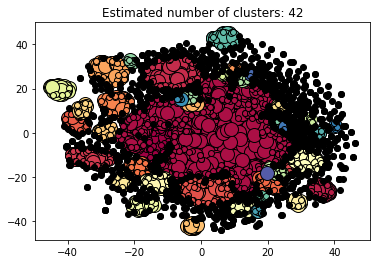

In [54]:
X = X_50_iter5000
# Compute DBSCAN
db = DBSCAN(eps=1.6, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


Build recommendation system

In [29]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)

def recommend_movies(user, num_recommendations):
    
    original_ratings = ratings
    # Get and sort the user's predictions
    user_row_number = user - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user == (user)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie', right_on = 'movie').
                     sort_values(['rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie'].isin(user_full['movie'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie',
               right_on = 'movie').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Top 5 recommendations for user #100

In [33]:
already_rated, predictions = recommend_movies(100, 5)
predictions

,movie,title,genres
1311,1374,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi
1148,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1312,1376,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi
285,296,Pulp Fiction (1994),Crime|Drama
570,590,Dances with Wolves (1990),Adventure|Drama|Western
